In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

In [3]:
def create_train_test_buckets(x_train, y_train, x_test, y_test):
    '''
    
    '''
    partitioned_train_arrays = {}
    numpy_partitioned_train_arrays = {}

    train_mix_fraction = 0.05
    test_mix_fraction = 0.05

    train_mix_length = int(len(x_train)*train_mix_fraction)
    test_mix_length = int(len(x_test)*test_mix_fraction)

    for item in zip(x_train,y_train):
        partitioned_train_arrays[item[1]]=([],[])

    for item in zip(x_train[:train_mix_length],y_train[:train_mix_length]):
        partitioned_train_arrays[item[1]][0].append(item[0])
        partitioned_train_arrays[item[1]][1].append(item[1])

    for item in zip(x_train[train_mix_length:],y_train[train_mix_length:]):
        random_bucket = int(np.random.randint(0,10,1))
        partitioned_train_arrays[random_bucket][0].append(item[0])
        partitioned_train_arrays[random_bucket][1].append(item[1])

    for item in partitioned_train_arrays:
        numpy_partitioned_train_arrays[item] = (np.array(partitioned_train_arrays[item][0]), np.array(partitioned_train_arrays[item][1]))

        
    partitioned_test_arrays = {}
    numpy_partitioned_test_arrays = {}


    for item in zip(x_test,y_test):
        partitioned_test_arrays[item[1]]=([],[])

    for item in zip(x_test[:test_mix_length],y_test[:test_mix_length]):
        partitioned_test_arrays[item[1]][0].append(item[0])
        partitioned_test_arrays[item[1]][1].append(item[1])

    for item in zip(x_test[test_mix_length:],y_test[test_mix_length:]):
        random_bucket = int(np.random.randint(0,10))
        partitioned_test_arrays[random_bucket][0].append(item[0])
        partitioned_test_arrays[random_bucket][1].append(item[1])


    for item in partitioned_test_arrays:
        partitioned_test_arrays[item] = (np.array(partitioned_test_arrays[item][0]), np.array(partitioned_test_arrays[item][1]))

    return(numpy_partitioned_train_arrays, partitioned_test_arrays)

In [4]:
partitioned_train_arrays, partitioned_test_arrays = create_train_test_buckets(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


In [5]:
partitioned_test_arrays[5][0].shape

(952, 28, 28)

(array([ 86.,  91., 106., 110.,  93.,  77.,  86., 111.,  83., 159.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

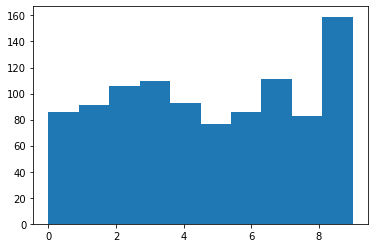

In [6]:
plt.hist(partitioned_test_arrays[9][1])

In [7]:
def create_keras_model():
    return tf.keras.models.Sequential([
        #tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(28, kernel_size=(5,5),input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(14, kernel_size=(5,5)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(84,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

'numpy_partitioned_train_arrays' is dictionary with 10 keys corresponding to 0,1, ..., 9 digits.

##### Create a global model

In [8]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

total model layers (10,)


In [9]:
models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = model_global

In [10]:
models_collection

{'model_0': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd66e8898>}

#### Create random sets of training data and train them models for them

In [11]:
def local_train(model, model_index, partitioned_train_arrays, partitioned_test_arrays, x_test, y_test, train_sample_count=100):
    x_train_reshaped = partitioned_train_arrays[model_index][0].reshape(-1,28,28,1)
    y_train_reshaped = partitioned_train_arrays[model_index][1]

    random_rows = np.random.choice(x_train_reshaped.shape[0], train_sample_count, replace=False)

    x_train_partitioned = x_train_reshaped[random_rows,:]
    y_train_partitioned = y_train_reshaped[random_rows]
    model.fit(x=x_train_partitioned, y=y_train_partitioned, epochs=1)
    
    x_test_partitioned = partitioned_test_arrays[model_index][0].reshape(-1,28,28,1)
    y_test_partitioned = partitioned_test_arrays[model_index][1]
    
    train_accuracy = model.evaluate(x_train_partitioned, y_train_partitioned)
    local_test_acciracy = model.evaluate(x_test_partitioned.reshape(-1,28,28,1), y_test_partitioned)
    global_test_accuracy = model.evaluate(x_test.reshape(-1,28,28,1), y_test)
    
    print('Accuracies: Training={}, Local Test={}, Global Test={}'.format(train_accuracy[1], local_test_acciracy[1], global_test_accuracy[1]))
    return(model, train_accuracy, local_test_acciracy, global_test_accuracy)
    

In [12]:
def average_models_weights(models_collection):
    '''
    '''
    
    weights = [models_collection[model].get_weights() for model in models_collection]

    new_weights = np.array(weights).mean(axis=0)

    new_model = create_keras_model()
    new_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    new_model.set_weights(new_weights)
    
    return(new_model)

In [13]:
training_round = 10
training_round_accuracies = []
train_sample_count=100
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        models_collection[model] = results[0]
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies.append(models_accuracies)
    print('Averaging Models')
    model_global = average_models_weights(models_collection)
    model_global.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
    print('total model layers', np.shape(model_global.layers))

    models_collection = {}
    for item in range(10):
        models_collection['model_{}'.format(item)] = model_global
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

Starting iteration: 0
Train on 100 samples
10000/10000 [==============================] - 2s 223us/sample - loss: 21.2773 - accuracy: 0.1834
Accuracies: Training=0.2800000011920929, Local Test=0.1693069338798523, Global Test=0.1834000051021576
Train on 100 samples
10000/10000 [==============================] - 2s 226us/sample - loss: 10.3534 - accuracy: 0.2981
Accuracies: Training=0.3499999940395355, Local Test=0.3184584081172943, Global Test=0.29809999465942383
Train on 100 samples
10000/10000 [==============================] - 3s 289us/sample - loss: 13.3172 - accuracy: 0.2389
Accuracies: Training=0.3400000035762787, Local Test=0.2587548494338989, Global Test=0.23890000581741333
Train on 100 samples
10000/10000 [==============================] - 2s 219us/sample - loss: 8.5030 - accuracy: 0.2942
Accuracies: Training=0.28999999165534973, Local Test=0.2698744833469391, Global Test=0.29420000314712524
Train on 100 samples
10000/10000 [==============================] - 2s 210us/sample - l

10000/10000 [==============================] - 2s 241us/sample - loss: 1.8077 - accuracy: 0.6220
Accuracies: Training=0.6600000262260437, Local Test=0.6256463527679443, Global Test=0.621999979019165
Train on 100 samples
10000/10000 [==============================] - 2s 220us/sample - loss: 1.8928 - accuracy: 0.6211
Accuracies: Training=0.6399999856948853, Local Test=0.6153081655502319, Global Test=0.6211000084877014
Train on 100 samples
10000/10000 [==============================] - 2s 245us/sample - loss: 1.8124 - accuracy: 0.6276
Accuracies: Training=0.6299999952316284, Local Test=0.602726399898529, Global Test=0.6276000142097473
Train on 100 samples
10000/10000 [==============================] - 2s 216us/sample - loss: 1.5088 - accuracy: 0.6563
Accuracies: Training=0.6800000071525574, Local Test=0.6556886434555054, Global Test=0.6563000082969666
Averaging Models
total model layers (10,)
Finieshed iteration: 1
Starting iteration: 2
Train on 100 samples
10000/10000 [==================

10000/10000 [==============================] - 2s 229us/sample - loss: 1.2019 - accuracy: 0.7177
Accuracies: Training=0.7099999785423279, Local Test=0.725680947303772, Global Test=0.7177000045776367
Train on 100 samples
10000/10000 [==============================] - 2s 220us/sample - loss: 1.1903 - accuracy: 0.7151
Accuracies: Training=0.7400000095367432, Local Test=0.6966527104377747, Global Test=0.7150999903678894
Train on 100 samples
10000/10000 [==============================] - 2s 227us/sample - loss: 1.1577 - accuracy: 0.7157
Accuracies: Training=0.7900000214576721, Local Test=0.7129455804824829, Global Test=0.7156999707221985
Train on 100 samples
10000/10000 [==============================] - 2s 216us/sample - loss: 1.1229 - accuracy: 0.7252
Accuracies: Training=0.8100000023841858, Local Test=0.7447478771209717, Global Test=0.7251999974250793
Train on 100 samples
10000/10000 [==============================] - 2s 229us/sample - loss: 1.1964 - accuracy: 0.7133
Accuracies: Training

10000/10000 [==============================] - 2s 210us/sample - loss: 0.8303 - accuracy: 0.7850
Accuracies: Training=0.800000011920929, Local Test=0.7887049913406372, Global Test=0.7850000262260437
Train on 100 samples
10000/10000 [==============================] - 2s 234us/sample - loss: 0.7565 - accuracy: 0.8050
Accuracies: Training=0.8500000238418579, Local Test=0.8043912053108215, Global Test=0.8050000071525574
Averaging Models
total model layers (10,)
Finieshed iteration: 4
Starting iteration: 5
Train on 100 samples
10000/10000 [==============================] - 2s 244us/sample - loss: 1.0044 - accuracy: 0.7654
Accuracies: Training=0.8299999833106995, Local Test=0.7841584086418152, Global Test=0.7653999924659729
Train on 100 samples
10000/10000 [==============================] - 3s 257us/sample - loss: 0.9251 - accuracy: 0.7608
Accuracies: Training=0.8299999833106995, Local Test=0.7555781006813049, Global Test=0.7608000040054321
Train on 100 samples
10000/10000 [=================

10000/10000 [==============================] - 2s 206us/sample - loss: 0.7501 - accuracy: 0.8208
Accuracies: Training=0.8899999856948853, Local Test=0.8189493417739868, Global Test=0.8208000063896179
Train on 100 samples
10000/10000 [==============================] - 2s 237us/sample - loss: 0.7415 - accuracy: 0.8322
Accuracies: Training=0.8100000023841858, Local Test=0.8382353186607361, Global Test=0.8321999907493591
Train on 100 samples
10000/10000 [==============================] - 2s 222us/sample - loss: 0.9297 - accuracy: 0.8014
Accuracies: Training=0.8399999737739563, Local Test=0.8128231763839722, Global Test=0.8014000058174133
Train on 100 samples
10000/10000 [==============================] - 2s 201us/sample - loss: 0.8903 - accuracy: 0.7989
Accuracies: Training=0.8500000238418579, Local Test=0.807157039642334, Global Test=0.7989000082015991
Train on 100 samples
10000/10000 [==============================] - 2s 212us/sample - loss: 0.7498 - accuracy: 0.8095
Accuracies: Training

10000/10000 [==============================] - 2s 216us/sample - loss: 0.6948 - accuracy: 0.8326
Accuracies: Training=0.8999999761581421, Local Test=0.8099009990692139, Global Test=0.8325999975204468
Train on 100 samples
10000/10000 [==============================] - 2s 202us/sample - loss: 0.8960 - accuracy: 0.7483
Accuracies: Training=0.75, Local Test=0.7535496950149536, Global Test=0.7483000159263611
Train on 100 samples
10000/10000 [==============================] - 2s 215us/sample - loss: 0.8242 - accuracy: 0.7531
Accuracies: Training=0.7900000214576721, Local Test=0.7577821016311646, Global Test=0.7530999779701233
Train on 100 samples
10000/10000 [==============================] - 2s 223us/sample - loss: 0.6191 - accuracy: 0.8116
Accuracies: Training=0.8199999928474426, Local Test=0.7991631627082825, Global Test=0.8116000294685364
Train on 100 samples
10000/10000 [==============================] - 2s 203us/sample - loss: 0.7180 - accuracy: 0.8127
Accuracies: Training=0.8199999928

10000/10000 [==============================] - 2s 208us/sample - loss: 0.7179 - accuracy: 0.8047
Accuracies: Training=0.8500000238418579, Local Test=0.7983453869819641, Global Test=0.8047000169754028
Train on 100 samples
10000/10000 [==============================] - 2s 203us/sample - loss: 0.7075 - accuracy: 0.8023
Accuracies: Training=0.9100000262260437, Local Test=0.8190854787826538, Global Test=0.802299976348877
Train on 100 samples
10000/10000 [==============================] - 2s 246us/sample - loss: 0.6795 - accuracy: 0.8108
Accuracies: Training=0.8700000047683716, Local Test=0.7955209612846375, Global Test=0.8108000159263611
Train on 100 samples
10000/10000 [==============================] - 2s 200us/sample - loss: 0.6578 - accuracy: 0.8333
Accuracies: Training=0.8199999928474426, Local Test=0.8433133959770203, Global Test=0.833299994468689
Averaging Models
total model layers (10,)
Finieshed iteration: 9


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


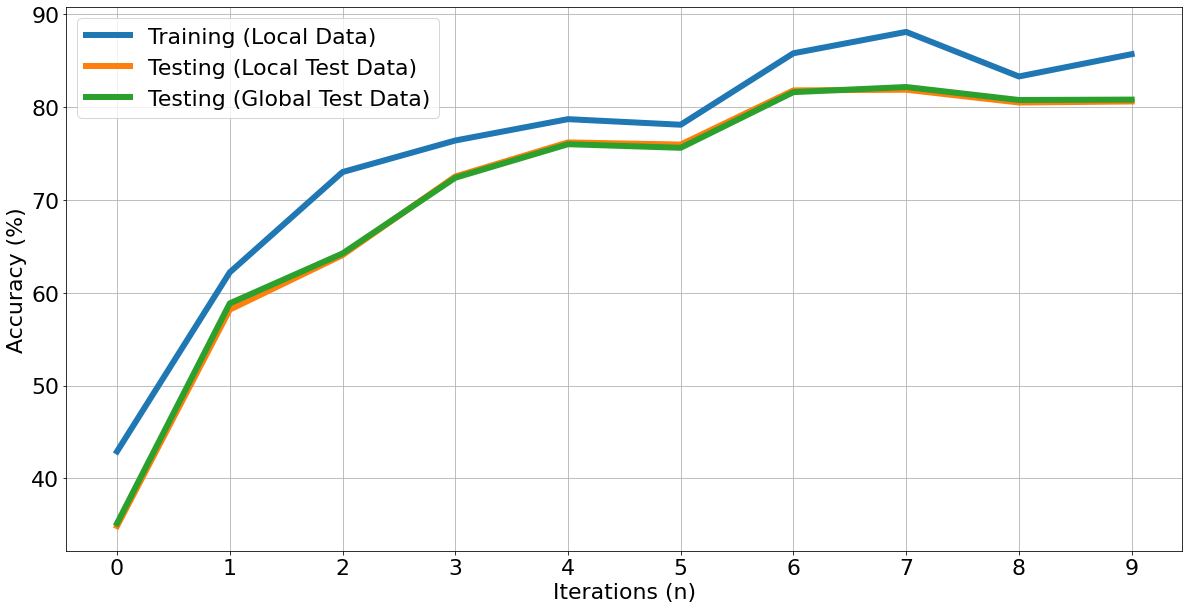

In [14]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
fig1, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))

